In [258]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [259]:
#input_file = "output_20191008_0336AM.csv" #complete
#input_file = "output_20191116_1256PM.csv" #partial
input_file = "output_20200219_2125PM.csv" #866 files
df = pd.read_csv(input_file, header = 0)

In [260]:
df['FLOW'] = df['SRCNODE']+'-'+df['DESTNODE']
df['FM']=df['FAILURE']+df['MISSING']

In [261]:
df_failure = df[ (df.FM==1)]
df_failure[:1]

,FILENAME,PATH,SRCNODE,DESTNODE,TIME_START,TIME_END,FILESIZE,THROUGHPUT,RETRIES,FAILURE,MISSING,SRC_R,DEST_S,LABEL,RUN,FLOW,FM
8,a12as_0107.pdb,20190425T121649-0700/00/00,CacheUC,OriginSDSC,2020-02-19 21:27:57,2020-02-19 21:27:57,301073,107 MB/s,0,1,0,CacheStarLightRouter,OriginSDSCRouter,CacheUC,run1,CacheUC-OriginSDSC,1


In [262]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
import graphviz 
from sklearn.calibration import CalibratedClassifierCV

In [263]:
df_dummy = pd.get_dummies(df_failure[['SRCNODE', 'DESTNODE','SRC_R','DEST_S','FM','RETRIES','FILESIZE','THROUGHPUT','LABEL']], prefix=['SRC', 'DEST','SRC_R','DEST_S'], columns=['SRCNODE', 'DESTNODE','SRC_R','DEST_S'])

In [264]:
df_dummy['THROUGHPUT']=df_dummy['THROUGHPUT'].str[0:-4]
df_dummy['THROUGHPUT']=pd.to_numeric(df_dummy['THROUGHPUT'], errors='coerce')
df_dummy = df_dummy.replace(np.nan, 0, regex=True)
y_complete=df_dummy['LABEL']
X_complete=df_dummy.drop(['LABEL'],axis=1)

In [265]:
print(len(df_dummy.columns))
X_complete[0:1]

47


,FM,RETRIES,FILESIZE,THROUGHPUT,SRC_CacheCal,SRC_CacheFNAL,SRC_CacheNY,SRC_CacheSDSC,SRC_CacheUC,SRC_CacheUNL,...,SRC_R_OriginUNLRouter,DEST_S_CacheCENICRouter,DEST_S_CacheNYRouter,DEST_S_CacheStarLightRouter,DEST_S_CacheUNLRouter,DEST_S_OriginCalRouter,DEST_S_OriginNCSARouter,DEST_S_OriginSDSCRouter,DEST_S_OriginStarLightRouter,DEST_S_OriginUNLRouter
8,1,0,301073,107.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [289]:
df_dummy_cate = pd.get_dummies(df_failure[['SRCNODE', 'DESTNODE','SRC_R','DEST_S','FM','RETRIES','THROUGHPUT','LABEL']], prefix=['SRC', 'DEST','SRC_R','DEST_S'], columns=['SRCNODE', 'DESTNODE','SRC_R','DEST_S'])
df_dummy_cate['THROUGHPUT']=df_dummy_cate['THROUGHPUT'].str[0:-4]
df_dummy_cate['THROUGHPUT']=pd.to_numeric(df_dummy_cate['THROUGHPUT'], errors='coerce')
df_dummy_cate = df_dummy_cate.replace(np.nan, 0, regex=True)
y_cate=df_dummy_cate['LABEL']
X_cate=df_dummy_cate.drop(['LABEL'],axis=1)
X_cate[0:1]

,FM,RETRIES,THROUGHPUT,SRC_CacheCal,SRC_CacheFNAL,SRC_CacheNY,SRC_CacheSDSC,SRC_CacheUC,SRC_CacheUNL,SRC_OriginCal,...,SRC_R_OriginUNLRouter,DEST_S_CacheCENICRouter,DEST_S_CacheNYRouter,DEST_S_CacheStarLightRouter,DEST_S_CacheUNLRouter,DEST_S_OriginCalRouter,DEST_S_OriginNCSARouter,DEST_S_OriginSDSCRouter,DEST_S_OriginStarLightRouter,DEST_S_OriginUNLRouter
8,1,0,107.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [290]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import multilabel_confusion_matrix,balanced_accuracy_score,f1_score

In [291]:
def accuracy(model, test_data, classes, k):
    if(k==0): return null,null
    num = classes.size
    correct_class={}
    correct=0
    for label in classes:
        label_pred=[]
        isCorrect=False
        test_data_1=test_data[test_data.LABEL==label]
        if test_data_1.shape[0]==0:
            print("No match")
            continue
        x_test_1=test_data_1.drop(['LABEL'],axis=1)
        test_prob_1 = model.predict_proba(x_test_1)
        label_array=test_prob_1.mean(axis=0)
        #label_array=np.nanmean(np.where(test_rf_prob_1!=0,test_rf_prob_1,np.nan),0)
        label_index = label_array.argmax()
        label_index_sort = label_array.argsort()
        #label_pred[0] = classes[label_index]
        for j in range(0,k): 
            if(j==0):
                label_pred.append(classes[label_index])
            else:
                label_pred.append(classes[label_index_sort[(-1)*j-1]])
            #print(j,label_pred[j],label)
            if(label==label_pred[j]):
                isCorrect=True
                break
               
        #print(label_pred)
        #print(isCorrect)
        if isCorrect:
            correct=correct+1
            correct_class[label]=1
        else:
            correct_class[label]=0
    return correct_class, correct, correct/num 

In [292]:
def print_s_c(c):
    s_c=sorted(c.items(), key=lambda x: x[1], reverse=True)
    num_link=0;num_host=0;link_pos=0;host_pos=0
    for i in s_c:
        name=i[0]
        flag=i[1]
        if 'Link' in name:
            num_link+=1
            if flag==1:
                link_pos+=1
        else:
            num_host+=1
            if flag==1:
                host_pos+=1
    return link_pos*1.0/num_link,host_pos*1.0/num_host

In [293]:
training_dataset={"complete":{"X":X_complete,
                 "y":y_complete},
                 "cate":{"X":X_cate,
                 "y":y_cate}}

In [294]:
def train_dt(classifier):
    df=[df_dummy,df_dummy_cate]
    i=0
    for k, d in training_dataset.items():
        X=d["X"]
        y=d['y']
        clf = classifier
        clf_model=clf.fit(X,y)
        pred=clf.predict(X)
        balanced_accu=balanced_accuracy_score(y, pred)
        f1=f1_score(y, pred,average='weighted')
        print(str(k)+":balanced_accu="+str(balanced_accu)+":F1-Score="+str(f1))
        for j in range(1,4):
            c,correct,accu=accuracy(clf_model, df[i], clf.classes_,j)
            print("Top-"+str(j)+" Accu="+str(accu)) 
        i=i+1

In [295]:
train_dt(DecisionTreeClassifier(max_depth = 20))

complete:balanced_accu=0.7143579744362497:F1-Score=0.7424526980951555
Top-1 Accu=0.9848484848484849
Top-2 Accu=1.0
Top-3 Accu=1.0
cate:balanced_accu=0.6178589584716364:F1-Score=0.6787488249173727
Top-1 Accu=0.9848484848484849
Top-2 Accu=0.9848484848484849
Top-3 Accu=0.9848484848484849


In [296]:
train_dt(RandomForestClassifier(max_depth=20, random_state=0))

complete:balanced_accu=0.9090387333369967:F1-Score=0.9144666402931019
Top-1 Accu=1.0
Top-2 Accu=1.0
Top-3 Accu=1.0
cate:balanced_accu=0.7375590305026882:F1-Score=0.789151058367541
Top-1 Accu=1.0
Top-2 Accu=1.0
Top-3 Accu=1.0


In [178]:
%%time
clf_complete = DecisionTreeClassifier(max_depth = 20)
clf_model_complete=clf_complete.fit(X_complete,y_complete)

CPU times: user 179 ms, sys: 9.48 ms, total: 189 ms
Wall time: 188 ms


In [181]:
c,correct,accu=accuracy(clf_model_complete, df_dummy, clf_complete.classes_,1)
print(str(correct)+":"+str(accu))
print(print_s_c(c))

65:0.9848484848484849
(1.0, 0.9166666666666666)


In [184]:
%%time
#clf_cate = DecisionTreeClassifier(max_depth = 20)
clf_cate = RandomForestClassifier(max_depth=2, random_state=0)
clf_model_cate=clf_cate.fit(X_cate,y_cate)

CPU times: user 492 ms, sys: 8.28 ms, total: 501 ms
Wall time: 506 ms


In [185]:
c,correct,accu=accuracy(clf_model_cate, df_dummy_cate, clf_cate.classes_,3)
print(str(correct)+":"+str(accu))
print(print_s_c(c))

15:0.22727272727272727
(0.2777777777777778, 0.0)


In [114]:
from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN,SMOTENC
from imblearn.combine import SMOTEENN, SMOTETomek

In [118]:
over_sampling = [SMOTE(random_state=0),
        SMOTEENN(random_state=0),
        SMOTETomek(random_state=0),
        SMOTENC(categorical_features=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43], random_state=0)

]

In [120]:
df=[df_dummy,df_dummy_cate]
i=0
for k, d in training_dataset.items():
    X=d["X"]
    y=d['y']
    for s in range(0,len(over_sampling)):
        print("sampling:"+str(s))
        os = over_sampling[s]
        X_resampled, y_resampled = os.fit_resample(X, y)
        clf = DecisionTreeClassifier(max_depth = 20)
        clf_model=clf.fit(X_resampled, y_resampled)
        pred=clf.predict(X)
        balanced_accu=balanced_accuracy_score(y, pred)
        f1=f1_score(y, pred,average='weighted')
        print(str(k)+":balanced_accu="+str(balanced_accu)+":F1-Score="+str(f1))
        for j in range(1,4):
            c,correct,accu=accuracy(clf_model, df[i], clf.classes_,j)
            print("Top-"+str(j)+" Accu="+str(accu)) 
    i=i+1

sampling:0
complete:balanced_accu=0.7497146108317648:F1-Score=0.707929536434961
Top-1 Accu=1.0
Top-2 Accu=1.0
Top-3 Accu=1.0
sampling:1
complete:balanced_accu=0.46990246701407884:F1-Score=0.2951990376270226
Top-1 Accu=0.7846153846153846
Top-2 Accu=0.9076923076923077
Top-3 Accu=0.9230769230769231
sampling:2
complete:balanced_accu=0.7082790697916143:F1-Score=0.6541881676497338
Top-1 Accu=1.0
Top-2 Accu=1.0
Top-3 Accu=1.0
sampling:3
complete:balanced_accu=0.7375445398531653:F1-Score=0.6956327311170871
Top-1 Accu=1.0
Top-2 Accu=1.0
Top-3 Accu=1.0
sampling:0
cate:balanced_accu=0.30006576690612485:F1-Score=0.3444248342076704
Top-1 Accu=0.7878787878787878
Top-2 Accu=0.803030303030303
Top-3 Accu=0.8181818181818182
sampling:1
cate:balanced_accu=0.15241042879848163:F1-Score=0.07775945307201444
Top-1 Accu=0.375
Top-2 Accu=0.4791666666666667
Top-3 Accu=0.5
sampling:2
cate:balanced_accu=0.30006576690612485:F1-Score=0.3444248342076704
Top-1 Accu=0.7878787878787878
Top-2 Accu=0.803030303030303
Top-3 

ValueError: could not broadcast input array from shape (11,80) into shape (151,80)

In [108]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_complete, y_complete)

In [109]:
clf_ros_model=clf.fit(X_resampled,y_resampled)

In [111]:
pred=clf.predict(X_complete)
balanced_accuracy_score(y_complete, pred)

0.7766651818487473

In [112]:
print_s_c(Counter(y_resampled))
c,correct,accu=accuracy(clf_ros_model, df_dummy, clf.classes_,1)
c,accu

CacheUC 1443
CacheFNAL 1443
CacheCal 1443
OriginFNAL 1443
CacheNY 1443
CacheUNL 1443
OriginUC 1443
CacheSDSC 1443
OriginNCSA 1443
OriginUNL 1443
OriginSDSC 1443
OriginCal 1443
CacheUC_Link25 1443
CacheFNAL_Link26 1443
CENIC_Link1 1443
CENIC_Link0 1443
CENIC_Link5 1443
CENIC_Link9 1443
CacheCal_Link19 1443
OriginFNAL_Link21 1443
CacheCENICRouter_Link4 1443
CacheCENICRouter_Link19 1443
CacheCENICRouter_Link18 1443
I2_Link6 1443
I2_Link13 1443
I2_Link2 1443
I2_Link3 1443
I2_Link14 1443
I2_Link27 1443
I2_Link0 1443
CacheNY_Link28 1443
CacheUNL_Link20 1443
OriginUC_Link11 1443
OriginSDSCRouter_Link17 1443
OriginSDSCRouter_Link5 1443
CacheSDSC_Link18 1443
OriginStarLightRouter_Link11 1443
OriginStarLightRouter_Link21 1443
OriginStarLightRouter_Link10 1443
OriginNCSA_Link15 1443
OriginUNLRouter_Link16 1443
OriginUNLRouter_Link14 1443
ESNET_Link4 1443
ESNET_Link2 1443
ESNET_Link22 1443
ESNET_Link7 1443
ESNET_Link1 1443
OriginUNL_Link16 1443
OriginSDSC_Link17 1443
OriginCalRouter_Link22 1443
Or

({'CENIC_Link0': 1,
  'CENIC_Link1': 1,
  'CENIC_Link5': 1,
  'CENIC_Link9': 1,
  'CacheCENICRouter_Link18': 1,
  'CacheCENICRouter_Link19': 1,
  'CacheCENICRouter_Link4': 1,
  'CacheCal': 1,
  'CacheCal_Link19': 1,
  'CacheFNAL': 1,
  'CacheFNAL_Link26': 1,
  'CacheNY': 1,
  'CacheNYRouter_Link27': 1,
  'CacheNYRouter_Link28': 1,
  'CacheNY_Link28': 1,
  'CacheSDSC': 1,
  'CacheSDSC_Link18': 1,
  'CacheStarLightRouter_Link24': 1,
  'CacheStarLightRouter_Link25': 1,
  'CacheStarLightRouter_Link26': 1,
  'CacheUC': 1,
  'CacheUC_Link25': 1,
  'CacheUNL': 1,
  'CacheUNLRouter_Link20': 1,
  'CacheUNLRouter_Link3': 1,
  'CacheUNL_Link20': 1,
  'ESNET_Link1': 1,
  'ESNET_Link2': 1,
  'ESNET_Link22': 1,
  'ESNET_Link4': 1,
  'ESNET_Link7': 1,
  'I2_Link0': 1,
  'I2_Link13': 1,
  'I2_Link14': 1,
  'I2_Link2': 1,
  'I2_Link27': 1,
  'I2_Link3': 1,
  'I2_Link6': 1,
  'OriginCal': 1,
  'OriginCalRouter_Link22': 1,
  'OriginCalRouter_Link23': 1,
  'OriginCal_Link23': 1,
  'OriginFNAL': 1,
  'Orig

In [193]:
X_resampled, y_resampled = SMOTE().fit_resample(x, y)
clf_smote_model=clf.fit(X_resampled,y_resampled)
pred=clf_smote_model.predict(x)
balanced_accuracy_score(y, pred)

0.7471497518594338

In [194]:
print(sorted(Counter(y_resampled).items()))
c,correct,accu=accuracy(clf_smote_model, df_dummy, clf.classes_,1)
c,accu

[('CENIC_Link0', 1443), ('CENIC_Link1', 1443), ('CENIC_Link5', 1443), ('CENIC_Link9', 1443), ('CacheCENICRouter_Link18', 1443), ('CacheCENICRouter_Link19', 1443), ('CacheCENICRouter_Link4', 1443), ('CacheCal', 1443), ('CacheCal_Link19', 1443), ('CacheFNAL', 1443), ('CacheFNAL_Link26', 1443), ('CacheNY', 1443), ('CacheNYRouter_Link27', 1443), ('CacheNYRouter_Link28', 1443), ('CacheNY_Link28', 1443), ('CacheSDSC', 1443), ('CacheSDSC_Link18', 1443), ('CacheStarLightRouter_Link24', 1443), ('CacheStarLightRouter_Link25', 1443), ('CacheStarLightRouter_Link26', 1443), ('CacheUC', 1443), ('CacheUC_Link25', 1443), ('CacheUNL', 1443), ('CacheUNLRouter_Link20', 1443), ('CacheUNLRouter_Link3', 1443), ('CacheUNL_Link20', 1443), ('ESNET_Link1', 1443), ('ESNET_Link2', 1443), ('ESNET_Link22', 1443), ('ESNET_Link4', 1443), ('ESNET_Link7', 1443), ('I2_Link0', 1443), ('I2_Link13', 1443), ('I2_Link14', 1443), ('I2_Link2', 1443), ('I2_Link27', 1443), ('I2_Link3', 1443), ('I2_Link6', 1443), ('OriginCal', 14

({'CENIC_Link0': 1,
  'CENIC_Link1': 1,
  'CENIC_Link5': 1,
  'CENIC_Link9': 1,
  'CacheCENICRouter_Link18': 1,
  'CacheCENICRouter_Link19': 1,
  'CacheCENICRouter_Link4': 1,
  'CacheCal': 1,
  'CacheCal_Link19': 1,
  'CacheFNAL': 1,
  'CacheFNAL_Link26': 1,
  'CacheNY': 1,
  'CacheNYRouter_Link27': 1,
  'CacheNYRouter_Link28': 1,
  'CacheNY_Link28': 1,
  'CacheSDSC': 1,
  'CacheSDSC_Link18': 1,
  'CacheStarLightRouter_Link24': 1,
  'CacheStarLightRouter_Link25': 1,
  'CacheStarLightRouter_Link26': 1,
  'CacheUC': 1,
  'CacheUC_Link25': 1,
  'CacheUNL': 1,
  'CacheUNLRouter_Link20': 1,
  'CacheUNLRouter_Link3': 1,
  'CacheUNL_Link20': 1,
  'ESNET_Link1': 1,
  'ESNET_Link2': 1,
  'ESNET_Link22': 1,
  'ESNET_Link4': 1,
  'ESNET_Link7': 1,
  'I2_Link0': 1,
  'I2_Link13': 1,
  'I2_Link14': 1,
  'I2_Link2': 1,
  'I2_Link27': 1,
  'I2_Link3': 1,
  'I2_Link6': 1,
  'OriginCal': 1,
  'OriginCalRouter_Link22': 1,
  'OriginCalRouter_Link23': 1,
  'OriginCal_Link23': 1,
  'OriginFNAL': 1,
  'Orig

In [195]:
smote_nc = SMOTENC(categorical_features=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43], random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(x, y)
clf_smotenc_model=clf.fit(X_resampled,y_resampled)
pred=clf_smotenc_model.predict(x)
balanced_accuracy_score(y, pred)

0.7363367774392485

In [196]:
X_resampled, y_resampled = ADASYN().fit_resample(x, y)
clf_adasyn_model=clf.fit(X_resampled,y_resampled)
pred=clf_adasyn_model.predict(x)
balanced_accuracy_score(y, pred)

ValueError: No samples will be generated with the provided ratio settings.

In [ ]:
print(sorted(Counter(y_resampled).items()))
c,correct,accu=accuracy(clf_smote_model, df_dummy, clf.classes_,3)
c,accu

In [197]:
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler
#cc = ClusterCentroids(random_state=0)
cc = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = cc.fit_resample(x, y)
print(sorted(Counter(y_resampled).items()))

[('CENIC_Link0', 11), ('CENIC_Link1', 11), ('CENIC_Link5', 11), ('CENIC_Link9', 11), ('CacheCENICRouter_Link18', 11), ('CacheCENICRouter_Link19', 11), ('CacheCENICRouter_Link4', 11), ('CacheCal', 11), ('CacheCal_Link19', 11), ('CacheFNAL', 11), ('CacheFNAL_Link26', 11), ('CacheNY', 11), ('CacheNYRouter_Link27', 11), ('CacheNYRouter_Link28', 11), ('CacheNY_Link28', 11), ('CacheSDSC', 11), ('CacheSDSC_Link18', 11), ('CacheStarLightRouter_Link24', 11), ('CacheStarLightRouter_Link25', 11), ('CacheStarLightRouter_Link26', 11), ('CacheUC', 11), ('CacheUC_Link25', 11), ('CacheUNL', 11), ('CacheUNLRouter_Link20', 11), ('CacheUNLRouter_Link3', 11), ('CacheUNL_Link20', 11), ('ESNET_Link1', 11), ('ESNET_Link2', 11), ('ESNET_Link22', 11), ('ESNET_Link4', 11), ('ESNET_Link7', 11), ('I2_Link0', 11), ('I2_Link13', 11), ('I2_Link14', 11), ('I2_Link2', 11), ('I2_Link27', 11), ('I2_Link3', 11), ('I2_Link6', 11), ('OriginCal', 11), ('OriginCalRouter_Link22', 11), ('OriginCalRouter_Link23', 11), ('OriginC

In [198]:
clf_cc_model=clf.fit(X_resampled,y_resampled)
pred=clf_cc_model.predict(x)
balanced_accuracy_score(y, pred)

0.4466799745970823

In [199]:
c,correct,accu=accuracy(clf_smote_model, df_dummy, clf.classes_,1)
c,accu

({'CENIC_Link0': 1,
  'CENIC_Link1': 1,
  'CENIC_Link5': 1,
  'CENIC_Link9': 1,
  'CacheCENICRouter_Link18': 1,
  'CacheCENICRouter_Link19': 1,
  'CacheCENICRouter_Link4': 1,
  'CacheCal': 1,
  'CacheCal_Link19': 1,
  'CacheFNAL': 1,
  'CacheFNAL_Link26': 1,
  'CacheNY': 1,
  'CacheNYRouter_Link27': 0,
  'CacheNYRouter_Link28': 1,
  'CacheNY_Link28': 1,
  'CacheSDSC': 1,
  'CacheSDSC_Link18': 1,
  'CacheStarLightRouter_Link24': 1,
  'CacheStarLightRouter_Link25': 1,
  'CacheStarLightRouter_Link26': 1,
  'CacheUC': 1,
  'CacheUC_Link25': 1,
  'CacheUNL': 1,
  'CacheUNLRouter_Link20': 0,
  'CacheUNLRouter_Link3': 1,
  'CacheUNL_Link20': 0,
  'ESNET_Link1': 1,
  'ESNET_Link2': 1,
  'ESNET_Link22': 1,
  'ESNET_Link4': 1,
  'ESNET_Link7': 1,
  'I2_Link0': 1,
  'I2_Link13': 1,
  'I2_Link14': 1,
  'I2_Link2': 1,
  'I2_Link27': 1,
  'I2_Link3': 1,
  'I2_Link6': 1,
  'OriginCal': 1,
  'OriginCalRouter_Link22': 1,
  'OriginCalRouter_Link23': 1,
  'OriginCal_Link23': 1,
  'OriginFNAL': 1,
  'Orig

'simple.pdf'

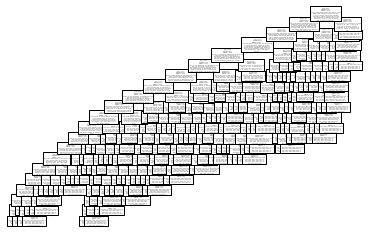

In [87]:
tree.plot_tree(clf.fit(x,y))
dot_data = tree.export_graphviz(clf_model, out_file=None,
                         feature_names=x.columns, 
                         class_names=clf.classes_,
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data) 
graph.render("simple")

In [88]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import multilabel_confusion_matrix,balanced_accuracy_score,f1_score

In [89]:
clf_model.classes_

array(['CENIC_Link0', 'CENIC_Link1', 'CENIC_Link5', 'CENIC_Link9',
       'CacheCENICRouter_Link18', 'CacheCENICRouter_Link19',
       'CacheCENICRouter_Link4', 'CacheCal', 'CacheCal_Link19',
       'CacheFNAL', 'CacheFNAL_Link26', 'CacheNY', 'CacheNYRouter_Link27',
       'CacheNYRouter_Link28', 'CacheNY_Link28', 'CacheSDSC',
       'CacheSDSC_Link18', 'CacheStarLightRouter_Link24',
       'CacheStarLightRouter_Link25', 'CacheStarLightRouter_Link26',
       'CacheUC', 'CacheUC_Link25', 'CacheUNL', 'CacheUNLRouter_Link20',
       'CacheUNLRouter_Link3', 'CacheUNL_Link20', 'ESNET_Link1',
       'ESNET_Link2', 'ESNET_Link22', 'ESNET_Link4', 'ESNET_Link7',
       'I2_Link0', 'I2_Link13', 'I2_Link14', 'I2_Link2', 'I2_Link27',
       'I2_Link3', 'I2_Link6', 'OriginCal', 'OriginCalRouter_Link22',
       'OriginCalRouter_Link23', 'OriginCal_Link23', 'OriginFNAL',
       'OriginFNAL_Link21', 'OriginNCSA', 'OriginNCSARouter_Link13',
       'OriginNCSARouter_Link15', 'OriginNCSA_Link15', 'Origin

In [90]:
print(x[:1])

   FM  RETRIES  SRC_CacheCal  SRC_CacheFNAL  SRC_CacheNY  SRC_CacheSDSC  \
8   1        0             0              0            0              0   

   SRC_CacheUC  SRC_CacheUNL  SRC_OriginCal  SRC_OriginFNAL  ...  \
8            1             0              0               0  ...   

   DEST_CacheNY  DEST_CacheSDSC  DEST_CacheUC  DEST_CacheUNL  DEST_OriginCal  \
8             0               0             0              0               0   

   DEST_OriginFNAL  DEST_OriginNCSA  DEST_OriginSDSC  DEST_OriginUC  \
8                0                0                1              0   

   DEST_OriginUNL  
8               0  

[1 rows x 26 columns]


In [91]:
df_failure.head

<bound method NDFrame.head of                FILENAME                        PATH    SRCNODE    DESTNODE  \
8        a12as_0107.pdb  20190425T121649-0700/00/00    CacheUC  OriginSDSC   
7144     a12as_0107.pdb  20190425T121649-0700/00/00    CacheUC    OriginUC   
27660    a12as_0107.pdb  20190425T121649-0700/00/00    CacheUC     CacheNY   
40148    a12as_0107.pdb  20190425T121649-0700/00/00    CacheUC  OriginNCSA   
64232    a12as_0107.pdb  20190425T121649-0700/00/00    CacheUC   OriginCal   
...                 ...                         ...        ...         ...   
7999451  a12as_0035.pdb  20190425T121649-0700/01/00  OriginCal  OriginFNAL   
7999452  design.resfile  20190425T121649-0700/01/00  OriginCal  OriginFNAL   
7999453  a12as_0032.pdb  20190425T121649-0700/01/00  OriginCal  OriginFNAL   
7999454  repack.resfile  20190425T121649-0700/01/00  OriginCal  OriginFNAL   
7999455  a12as_0006.pdb  20190425T121649-0700/01/00  OriginCal  OriginFNAL   

                  TIME_START     

In [92]:
test_prob = clf_model.predict_proba(x[:1])
test_prob

array([[0.        , 0.        , 0.00829876, 0.16182573, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00414938, 0.13692946, 0.        ,
        0.00414938, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00829876,
        0.16182573, 0.37759336, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.12448133, 0.        , 0.        ,
        0.01244813]])

In [93]:
cross_val_score(clf, x, y, scoring='accuracy',cv=5)

array([0.08541252, 0.21102749, 0.25357747, 0.29187856, 0.20271731])

In [94]:
clf_model.score(x,y)

0.3774339413700821

In [95]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [96]:
y_pred = clf.fit(x_train, y_train).predict(x_test)

In [97]:
y_test.shape,y_pred.shape

((8128,), (8128,))

In [98]:
balanced_accuracy_score(y_test, y_pred)

0.2039690663592467

In [99]:
f1_score(y_test, y_pred,average='weighted')

/Users/yxin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.30497340444731347

In [100]:
test_prob = clf_model.predict_proba(x_train[:1])

In [101]:
test_prob

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.18285714, 0.        ,
        0.02285714, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01142857,
        0.19428571, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.19428571, 0.01142857, 0.        ,
        0.        , 0.19428571, 0.        , 0.        , 0.        ,
        0.        , 0.01142857, 0.        , 0.        , 0.17714286,
        0.        ]])

In [102]:
clf_model.classes_[26]

'ESNET_Link1'

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [104]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=30, min_samples_split=2, random_state=0)

In [105]:
clf_rf_model=clf_rf.fit(x, y)

In [106]:
c,r=accuracy(clf_rf_model, df_dummy, clf.classes_,3)
c,r

(54, 0.8181818181818182)

In [107]:
clf_rf_model.score(x,y)

0.37780306991909934

In [108]:
clf_extra = ExtraTreesClassifier(n_estimators=10, max_depth=20, min_samples_split=2, random_state=0)

In [109]:
cross_val_score(clf_extra, x, y, cv=5)

array([0.08541252, 0.21886039, 0.2580397 , 0.29187856, 0.2028717 ])

In [110]:
clf_extra_model=clf_extra.fit(x, y)

In [111]:
c,r=accuracy(clf_extra_model, df_dummy, clf.classes_,3)
c,r

(53, 0.803030303030303)

In [112]:
clf_extra_model.score(x,y)

0.37749546279491836

In [113]:
y_pred_extra = clf_extra.fit(x_train, y_train).predict(x_test)
balanced_accuracy_score(y_test, y_pred_extra)

0.20484249755739944

In [114]:
y_pred = clf_model.predict(x)
balanced_accuracy_score(y, y_pred)

0.22003122895056715

In [115]:
y_pred_rf = clf_rf_model.predict(x)
balanced_accuracy_score(y, y_pred_rf)

0.22599816112825222

In [116]:
y_pred_extra = clf_extra_model.predict(x)
balanced_accuracy_score(y, y_pred_extra)

0.21926639011668567

In [117]:
f1_score(y, y_pred_rf,average='weighted')

/Users/yxin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.32663343311587506

In [118]:
df_dummy_1=df_dummy[df_dummy.LABEL=='I2_Link0']

In [119]:
x_test_1=df_dummy_1.drop(['LABEL'],axis=1)
test_prob_1 = clf_model.predict_proba(x_test_1)
test_prob_1.shape, x_test_1.shape

((158, 66), (158, 26))

In [120]:
test_prob_1.sum(axis=0).argmax()

2

In [121]:
clf_model.classes_[26]

'ESNET_Link1'

In [122]:
test_prob_1[0]

array([0.18918919, 0.        , 0.00675676, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00675676, 0.18918919, 0.01351351,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00675676, 0.        , 0.        , 0.        ,
       0.        , 0.19594595, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02702703,
       0.17567568, 0.18918919, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [123]:
test_rf_prob_1 = clf_rf.predict_proba(x_test_1)
test_rf_prob_1.shape, x_test_1.shape

((158, 66), (158, 26))

In [124]:
test_rf_prob_1[100]

array([0.00591349, 0.        , 0.16020665, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16949997, 0.01482358, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16800855, 0.01418881, 0.23383911, 0.00453821, 0.20925909,
       0.01002527, 0.00969727, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [125]:
#label_array=np.nanmean(np.where(test_prob_1!=0,test_prob_1,np.nan),axis=0)
#label_array=test_rf_prob_1.mean(axis=0)
label_array=np.true_divide(test_prob_1.sum(0),(test_prob_1!=0).sum(0))

/Users/yxin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [126]:
label_array.argmax()

1

In [127]:
clf_model.classes_[44]

'OriginNCSA'

In [128]:
test_rf_prob_1.sum(axis=0).argmax()

49

In [129]:
def accuracy_ori(model, test_data, classes):
    num = classes.size
    correct=0
    for label in classes:
        test_data_1=test_data[test_data.LABEL==label]
        if test_data_1.shape[0]==0:
            print("No match")
            continue
        x_test_1=test_data_1.drop(['LABEL'],axis=1)
        test_prob_1 = model.predict_proba(x_test_1)
        label_array=test_prob_1.mean(axis=0)
        #label_array=np.nanmean(np.where(test_rf_prob_1!=0,test_rf_prob_1,np.nan),0)
        label_index = label_array.argmax()
        label_index_sort = label_array.argsort()
        label_pred_1 = classes[label_index]
        label_pred_2 = classes[label_index_sort[-2]] 
        label_pred_3 = classes[label_index_sort[-3]] 
        print(label_array)
        print(label_index,label_index_sort[-1], label_index_sort[-2],label,label_pred_1,label_pred_2)
        if( (label==label_pred_1) | (label==label_pred_2) | (label==label_pred_3)):
            correct=correct+1
    return correct, correct/num

In [130]:
c,r=accuracy_ori(clf, df_dummy, clf_model.classes_)
c,r

[0.14084862 0.         0.17189945 0.         0.         0.
 0.         0.         0.         0.         0.         0.00170432
 0.00508051 0.04798078 0.01254707 0.         0.         0.
 0.         0.         0.         0.         0.00170038 0.04787367
 0.00682165 0.0039472  0.         0.         0.         0.
 0.         0.01961227 0.01513718 0.04041306 0.         0.0346059
 0.04944247 0.         0.         0.         0.         0.
 0.         0.         0.         0.00368029 0.01281896 0.00211692
 0.0003933  0.03004681 0.14224386 0.15534611 0.         0.
 0.         0.         0.         0.00168034 0.00195279 0.04536918
 0.00473689 0.         0.         0.         0.         0.        ]
2 2 51 CENIC_Link0 CENIC_Link5 OriginSDSC_Link17
[0.         0.18595556 0.06568488 0.         0.02077669 0.01552605
 0.01186478 0.00129384 0.0013104  0.         0.         0.
 0.         0.         0.         0.0018759  0.00368598 0.
 0.         0.         0.         0.         0.         0.
 0.       

 0.00000000e+00 0.00000000e+00]
14 14 12 CacheNYRouter_Link27 CacheNY_Link28 CacheNYRouter_Link27
[1.55738200e-02 0.00000000e+00 1.81134810e-03 0.00000000e+00
 2.69201080e-03 9.11386096e-03 2.82359738e-02 1.81847939e-05
 1.52940079e-02 1.66148836e-05 1.57145428e-02 4.29014033e-03
 2.42594463e-02 1.51241189e-01 8.87935318e-02 1.34271443e-05
 1.69898133e-02 3.14569420e-02 1.82724852e-03 1.36218808e-03
 2.94199850e-05 1.85597313e-02 2.37844369e-06 4.20303481e-04
 4.98519702e-03 6.58350594e-03 0.00000000e+00 4.29380652e-02
 2.12328064e-03 4.67448960e-03 0.00000000e+00 2.28494015e-03
 1.11349390e-03 2.65276824e-03 5.32288576e-03 1.50857990e-01
 7.69253651e-04 1.28455751e-02 0.00000000e+00 1.70002845e-02
 8.48376302e-04 1.51821920e-02 1.29502925e-04 1.29502925e-04
 4.12405147e-05 3.12044527e-02 1.54782438e-03 2.10577200e-02
 6.03782699e-05 3.88685112e-03 1.38511525e-02 1.61077903e-02
 2.08820196e-02 7.70765032e-03 6.53342255e-02 0.00000000e+00
 2.01849728e-02 7.80225953e-05 1.79372187e-02 3.

[0.00000000e+00 1.11775033e-02 2.11531357e-03 0.00000000e+00
 3.11455101e-02 3.07740561e-02 6.33869930e-02 1.52926281e-03
 3.64590058e-02 5.41943556e-06 1.26839510e-02 9.30916674e-06
 8.90825166e-03 1.75215455e-03 1.32298152e-02 2.08930610e-03
 1.27194123e-02 2.18906029e-02 2.32508946e-03 1.17302013e-03
 3.44853748e-06 1.27933919e-02 1.01661996e-05 7.81761260e-04
 7.13984956e-03 9.54297625e-03 1.00728416e-03 5.68127503e-03
 2.85755671e-02 3.67821717e-01 4.59118836e-03 0.00000000e+00
 1.50694158e-03 7.08645507e-04 3.99657564e-02 1.61665746e-03
 4.41749656e-03 0.00000000e+00 8.28825514e-04 1.43864632e-02
 2.72560226e-02 1.77743256e-02 1.85171469e-05 1.21828310e-02
 5.75532944e-06 1.03150667e-02 9.63742788e-04 1.13393167e-02
 2.22472091e-05 1.05172623e-03 1.08054781e-02 2.13244859e-02
 3.07529809e-02 1.21502045e-03 9.71559238e-04 0.00000000e+00
 1.37391217e-02 2.45119067e-05 1.21173668e-02 9.84404457e-04
 1.35893382e-02 6.79749051e-03 2.24314795e-03 0.00000000e+00
 4.97521544e-02 0.000000

[0.         0.         0.00055772 0.01450084 0.00048356 0.00197628
 0.01160542 0.         0.         0.         0.02123424 0.
 0.01529312 0.00382328 0.01486831 0.         0.0106383  0.03827783
 0.         0.00199071 0.         0.02211302 0.         0.00064475
 0.01482914 0.02321083 0.         0.         0.00059809 0.0029434
 0.0651095  0.         0.00189394 0.0012285  0.         0.00424809
 0.00064475 0.06689325 0.         0.0173445  0.00119617 0.01973684
 0.00666429 0.01125872 0.         0.01515152 0.00315657 0.01641414
 0.         0.00167317 0.01561629 0.01840491 0.0558853  0.0026738
 0.22029486 0.         0.04278075 0.         0.01535627 0.00061425
 0.01904177 0.16560862 0.00148257 0.00169924 0.00276138 0.00557724]
54 54 61 OriginFNAL OriginStarLightRouter_Link21 StarLight_Link10
[0.00000000e+00 0.00000000e+00 2.04513970e-02 1.31858331e-03
 1.05211840e-02 7.57261948e-03 2.48288613e-03 5.82509191e-04
 2.91254595e-03 8.41900035e-04 1.07639006e-03 0.00000000e+00
 3.87613592e-04 9.69033

[1.27723242e-02 0.00000000e+00 6.38616210e-04 0.00000000e+00
 4.17946628e-04 9.49851366e-04 3.42122390e-02 0.00000000e+00
 1.82758439e-02 1.57741147e-05 1.65182817e-02 3.67667335e-05
 2.00832071e-02 3.42278415e-03 2.09848615e-02 4.17946628e-05
 1.13573626e-02 3.39374250e-02 2.48673147e-03 1.41967032e-04
 2.38535393e-05 2.08301032e-02 2.26387757e-05 9.93986756e-03
 1.24460282e-02 1.37561871e-02 0.00000000e+00 4.44498605e-02
 2.04834919e-03 4.03288428e-03 0.00000000e+00 1.91584863e-03
 1.82583651e-03 1.81816754e-01 3.73049808e-03 6.29406729e-03
 1.90204250e-02 6.69084701e-03 3.21708918e-05 1.68221186e-02
 1.31371262e-03 2.01361277e-02 0.00000000e+00 1.78630429e-02
 4.55587784e-05 1.73608820e-02 1.87139529e-03 2.34866706e-02
 0.00000000e+00 1.91584863e-03 1.66040215e-02 1.78812539e-02
 2.71054823e-02 1.19302176e-03 1.54345753e-03 4.82246109e-06
 1.97663035e-02 5.67115709e-03 3.95104638e-02 1.76873357e-01
 1.97104001e-02 3.11582917e-03 6.26040551e-03 5.87746697e-02
 0.00000000e+00 0.000000

(53, 0.803030303030303)

In [131]:
c,r=accuracy_ori(clf_rf, df_dummy, clf_model.classes_)
c,r

[0.14821323 0.         0.17227028 0.         0.         0.
 0.         0.         0.         0.         0.         0.00124956
 0.00652647 0.04329314 0.01005408 0.         0.         0.
 0.         0.         0.         0.         0.00108015 0.04720524
 0.00546864 0.00436892 0.         0.         0.         0.
 0.         0.02000127 0.01414153 0.03859747 0.         0.04080849
 0.04681918 0.         0.         0.         0.         0.
 0.         0.         0.0003002  0.00399613 0.01331902 0.00223407
 0.0002959  0.02582267 0.14683537 0.15456598 0.         0.
 0.         0.         0.         0.00105292 0.00342545 0.0429028
 0.00515186 0.         0.         0.         0.         0.        ]
2 2 51 CENIC_Link0 CENIC_Link5 OriginSDSC_Link17
[0.         0.18590012 0.06355699 0.         0.02308005 0.02003441
 0.01166321 0.00106496 0.00117727 0.         0.         0.
 0.         0.         0.         0.00135174 0.00667275 0.
 0.         0.         0.         0.         0.         0.
 0.       

[0.00000000e+00 0.00000000e+00 3.98320619e-03 5.00941208e-04
 5.08071407e-03 4.43079632e-03 4.11397368e-02 1.37438274e-04
 2.20553219e-02 1.35277916e-03 5.38566544e-01 1.61001969e-04
 4.54510797e-04 5.42938080e-03 4.87261705e-04 1.44567157e-04
 1.87985757e-02 6.07481334e-02 1.28389721e-02 2.71737714e-02
 3.89858195e-04 6.95714265e-04 1.49891387e-04 5.35845572e-03
 3.32031133e-04 3.07273645e-04 0.00000000e+00 0.00000000e+00
 5.32525610e-03 1.13927001e-02 3.84042049e-02 0.00000000e+00
 5.33830686e-03 6.47424782e-03 0.00000000e+00 5.78522823e-03
 4.96283621e-03 8.08258837e-03 1.39609137e-04 4.94537848e-04
 5.50336526e-03 5.26260804e-04 1.91110426e-04 6.26467510e-04
 1.41153451e-04 1.14184103e-03 5.39297789e-03 1.28607936e-03
 1.00028592e-04 3.97435063e-03 3.82589583e-04 5.30616402e-03
 1.34778604e-03 6.41233884e-03 7.06244876e-03 2.03137653e-04
 4.23214290e-04 1.45018454e-04 4.71894274e-03 5.35221976e-03
 4.82868290e-03 1.37261929e-02 4.94561254e-02 2.24121224e-02
 1.84908712e-02 3.732117

[0.00000000e+00 0.00000000e+00 2.26069123e-03 1.45634162e-02
 1.58476741e-03 1.68359892e-03 9.91283679e-03 7.64008468e-05
 4.69156488e-03 7.81196064e-03 1.62612291e-01 4.85079593e-05
 1.61435216e-02 2.09828659e-03 1.89138697e-02 4.76229546e-05
 5.17365373e-03 3.04083880e-02 1.04801330e-02 1.50239097e-01
 1.18547189e-04 2.11551203e-04 4.80423400e-05 3.54821077e-03
 1.92602044e-02 1.62225421e-02 0.00000000e+00 0.00000000e+00
 1.85073912e-03 4.74445766e-03 1.55365434e-02 0.00000000e+00
 4.93992540e-03 1.17194028e-03 0.00000000e+00 2.15794220e-03
 1.59066021e-03 6.69604877e-02 4.24520271e-05 4.73063159e-03
 2.04892212e-03 5.70642754e-03 1.61884603e-04 2.11756514e-02
 1.02069703e-04 1.43103653e-02 5.11437645e-03 1.69414139e-02
 3.48894752e-05 2.20631249e-03 1.47590340e-02 2.06992742e-02
 3.92767459e-02 2.10182236e-03 6.50023584e-03 2.93782401e-05
 2.31313503e-02 0.00000000e+00 1.38057918e-02 3.99480832e-04
 1.46234352e-02 7.93622380e-03 1.29130817e-01 1.02651409e-02
 6.54652212e-02 2.188249

[5.02267389e-03 0.00000000e+00 6.63523656e-02 0.00000000e+00
 5.95433636e-04 2.11541565e-03 3.38373877e-02 3.70928489e-05
 1.85213591e-02 4.17351532e-05 1.66918220e-02 0.00000000e+00
 1.82223727e-02 1.03603123e-03 2.31468020e-02 9.37224155e-06
 1.63081285e-02 3.11426089e-02 9.68335508e-04 2.72835227e-03
 1.52493531e-05 1.87954114e-02 3.70731416e-05 2.23939878e-03
 1.87834811e-02 2.47627642e-02 0.00000000e+00 3.20653552e-02
 1.30176002e-03 3.47866426e-03 0.00000000e+00 1.34733889e-03
 1.49803301e-01 2.24991797e-03 4.75100115e-03 2.22692638e-03
 2.86787908e-03 1.07176871e-02 3.03058371e-05 3.08859654e-03
 1.47065529e-03 3.43806089e-03 3.36248897e-05 1.87469010e-02
 4.22167053e-03 2.03224847e-02 1.52201425e-01 1.09969062e-01
 3.23387916e-05 1.78585839e-03 5.82178589e-03 5.94159451e-03
 3.84002734e-02 6.54734266e-03 1.52437010e-03 0.00000000e+00
 9.40351886e-03 2.68815058e-05 1.27593438e-02 1.99451804e-03
 1.61270814e-02 3.31140028e-03 3.52680048e-03 6.70140200e-02
 3.95882819e-05 0.000000

[0.00000000e+00 9.16399293e-03 7.51682376e-03 0.00000000e+00
 7.75763530e-03 6.26121815e-03 1.23308879e-03 2.42589712e-04
 9.35625682e-04 5.77460314e-05 6.88831709e-04 1.94849246e-04
 1.21739161e-03 7.94791504e-03 1.40432578e-03 3.11702339e-04
 0.00000000e+00 2.63995417e-03 7.35522030e-03 1.37963174e-03
 2.22584730e-04 4.57337763e-04 1.39116702e-04 5.52174427e-03
 8.88614083e-04 7.86097650e-04 6.67892810e-03 2.57531485e-02
 4.03342814e-02 2.18276756e-02 3.04990576e-02 0.00000000e+00
 1.59021130e-03 7.35385819e-03 3.19661939e-03 6.82337002e-03
 5.56803393e-03 0.00000000e+00 9.91223145e-04 8.12925115e-02
 5.38321012e-02 4.18254653e-01 1.93446519e-04 3.65084371e-02
 4.08510968e-05 6.82378844e-04 1.68875904e-03 3.82103187e-02
 1.97379440e-04 6.39982817e-03 3.80192794e-04 2.35639445e-04
 2.66480842e-02 6.35942391e-03 7.80279096e-03 1.80888603e-04
 1.17828402e-03 2.56608535e-04 1.61949485e-03 7.88651963e-03
 2.24596927e-03 1.35760262e-02 1.16387909e-02 0.00000000e+00
 6.77501777e-02 0.000000

[0.00000000e+00 0.00000000e+00 6.49609756e-04 6.62735465e-03
 2.76643342e-04 8.22099878e-04 5.25100483e-03 8.94651068e-06
 5.39606197e-05 9.32977912e-06 1.07547561e-02 8.75963832e-04
 9.54260838e-03 3.17460709e-02 9.47782953e-03 6.47826350e-06
 5.34052592e-03 1.88600815e-02 7.33865906e-04 1.81522887e-03
 6.08380109e-06 9.45198531e-03 3.40768960e-05 1.72616598e-03
 7.83437175e-03 8.92133079e-03 0.00000000e+00 0.00000000e+00
 2.06316847e-04 2.00287947e-03 2.81548268e-02 0.00000000e+00
 7.21121216e-04 1.11490120e-03 0.00000000e+00 3.28096649e-02
 1.83478649e-03 3.05165282e-02 0.00000000e+00 8.73691829e-03
 3.75013124e-04 7.99350383e-03 2.79142155e-03 9.28805919e-03
 7.09123995e-06 6.64330405e-03 1.38244074e-03 7.42973588e-03
 1.22122932e-05 9.78856468e-04 6.94259158e-03 7.86273706e-03
 5.78290559e-02 1.62414652e-03 4.84484956e-01 1.38603460e-05
 2.20951855e-02 1.33077209e-05 9.26589064e-03 8.05116971e-04
 9.78601448e-03 7.94507541e-02 9.96059881e-04 3.94567303e-02
 2.43928219e-03 3.108355

(54, 0.8181818181818182)

In [132]:
c,r=accuracy_ori(clf_extra, df_dummy, clf_model.classes_)
c,r

[0.14084862 0.         0.17189945 0.         0.         0.
 0.         0.         0.         0.         0.         0.00170432
 0.00508051 0.04798078 0.01254707 0.         0.         0.
 0.         0.         0.         0.         0.00170038 0.04787367
 0.00682165 0.0039472  0.         0.         0.         0.
 0.         0.01961227 0.01513718 0.04041306 0.         0.0346059
 0.04944247 0.         0.         0.         0.         0.
 0.         0.         0.         0.00368029 0.01281896 0.00211692
 0.0003933  0.03004681 0.14224386 0.15534611 0.         0.
 0.         0.         0.         0.00168034 0.00195279 0.04536918
 0.00473689 0.         0.         0.         0.         0.        ]
2 2 51 CENIC_Link0 CENIC_Link5 OriginSDSC_Link17
[0.00000000e+00 1.82057674e-01 6.51588566e-02 2.91806958e-03
 1.88677446e-02 1.58095079e-02 1.16121855e-02 1.31745899e-03
 1.31040131e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70236146e-03
 3.6859826

[0.00000000e+00 3.56652949e-04 7.85015059e-04 1.12078672e-02
 1.35089156e-03 2.85193679e-03 2.01898577e-02 1.54539937e-04
 3.40764336e-03 2.12652844e-04 3.17766251e-02 3.31354518e-05
 1.29791569e-02 1.74347661e-03 1.46750970e-02 8.81024156e-05
 1.28374267e-02 3.48703089e-02 2.14458193e-01 4.59392966e-03
 4.01375080e-03 2.74897510e-02 1.58137144e-05 1.29933025e-03
 1.38694811e-02 1.22288532e-02 1.37174211e-05 3.58821810e-04
 1.17138150e-03 9.02091511e-03 2.75106218e-02 0.00000000e+00
 9.08927065e-04 1.86230593e-02 2.41829007e-03 2.18536586e-03
 7.52454271e-04 6.54306360e-02 0.00000000e+00 1.13778686e-02
 1.14867480e-03 1.33440861e-02 5.17978173e-05 3.29931783e-02
 1.40291807e-05 1.44931677e-02 8.94897884e-04 1.54833002e-02
 0.00000000e+00 1.09061217e-03 1.00300173e-02 2.53869616e-02
 4.42422430e-02 3.02723116e-03 2.47679557e-03 0.00000000e+00
 1.51790343e-02 3.85217287e-05 2.43807953e-02 3.38745240e-03
 2.68050377e-02 6.87722482e-03 1.22838924e-01 1.77243165e-02
 4.96582643e-02 1.171888

[1.24768264e-02 0.00000000e+00 1.14479782e-03 0.00000000e+00
 8.23781985e-03 6.87350582e-03 8.85150002e-02 3.84691261e-05
 1.53277485e-02 0.00000000e+00 1.35986401e-02 1.60776874e-05
 1.77616223e-03 4.78158039e-04 9.08243628e-03 4.72446185e-05
 2.75831115e-02 1.47985201e-02 8.08482463e-04 8.49915008e-04
 2.07365627e-05 3.60402271e-03 3.85952610e-03 1.21470735e-01
 3.54370146e-02 4.66417963e-02 0.00000000e+00 4.60404986e-02
 1.91646058e-03 1.13765443e-02 4.60721255e-05 1.04811874e-03
 4.16283796e-03 1.26827285e-02 1.05738646e-02 4.12036025e-02
 1.66598619e-01 4.27776242e-03 1.43686419e-05 8.50107978e-03
 2.10757727e-02 1.00870616e-02 4.02127576e-05 9.10612929e-03
 1.31271781e-04 1.44668248e-02 4.30440591e-03 1.55179840e-02
 2.41697685e-05 2.57310048e-03 1.15649076e-02 1.24526566e-02
 2.13342022e-02 1.83174977e-03 3.46589284e-03 0.00000000e+00
 1.40884114e-02 4.85323808e-04 1.52213095e-02 1.36428736e-02
 1.92469041e-02 2.96510061e-03 3.60191254e-02 4.85035084e-02
 7.21796632e-04 0.000000

[0.00000000e+00 6.09189820e-05 1.72814370e-02 2.63232006e-03
 1.00538280e-02 1.04963496e-02 1.10338418e-02 4.93371876e-04
 3.42654557e-03 7.08451914e-04 1.30696427e-03 3.11811741e-04
 5.72174175e-03 9.49683726e-03 5.77512349e-03 6.03517710e-04
 8.55757407e-03 1.17437824e-02 2.21607490e-02 8.22560648e-03
 2.71218029e-04 4.35935876e-03 2.29698037e-04 1.25672516e-02
 3.37723742e-04 1.30259759e-03 2.34303777e-06 7.85725481e-06
 9.16851125e-03 3.85657354e-02 1.63329537e-02 0.00000000e+00
 1.69716458e-02 9.95908483e-03 1.96511825e-04 1.01217583e-02
 1.19994155e-02 9.63497726e-03 7.29011752e-05 1.91412997e-03
 1.00236343e-02 2.59999006e-02 4.34038143e-04 7.46098009e-02
 6.64666615e-04 1.72323241e-03 1.50911282e-02 1.13479880e-03
 5.66310232e-04 1.40673868e-02 2.53635343e-03 3.53548476e-03
 1.94060389e-01 1.59190734e-02 5.17621557e-02 3.57725402e-05
 8.90072310e-02 3.87728214e-04 6.63229565e-03 1.02733740e-02
 1.32644185e-03 3.68775261e-02 3.21031318e-02 7.18010457e-02
 4.93885233e-02 1.593213

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.20482350e-02 1.08450704e-02 1.90506665e-02 5.57896927e-04
 1.73286867e-02 7.07656790e-04 1.82409797e-02 9.73084666e-06
 8.57883478e-04 4.55612425e-04 1.13270105e-03 7.47267592e-04
 2.03299883e-03 3.33895013e-02 1.53769821e-02 1.10309880e-02
 6.81108091e-04 4.80346519e-02 0.00000000e+00 2.96356166e-04
 0.00000000e+00 4.04122045e-05 0.00000000e+00 1.22128171e-04
 1.73452334e-02 4.08430697e-02 4.37012306e-02 0.00000000e+00
 0.00000000e+00 4.26063562e-04 5.50595746e-04 4.49304027e-04
 3.50239106e-04 4.83008315e-04 6.69169971e-05 2.23617125e-02
 1.90582798e-02 4.61864948e-02 5.22503457e-05 1.32824848e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.38257033e-02 1.58966635e-03 1.72705079e-03 5.06890108e-06
 1.69637154e-02 9.58129731e-06 3.58994481e-05 4.56384059e-04
 3.58994481e-05 6.91657175e-03 3.76717489e-02 1.02585103e-03
 5.01592462e-01 0.000000

(53, 0.803030303030303)

In [133]:
test_file = "output_20191116_1256PM.csv"
test_df = pd.read_csv(test_file, header = 0)
test_df['FLOW'] = test_df['SRCNODE']+'-'+test_df['DESTNODE']
test_df['FM']=test_df['FAILURE']+test_df['MISSING']
test_df_failure = test_df[ (test_df.FM==1)]
test_dummy = pd.get_dummies(test_df_failure[['SRCNODE', 'DESTNODE','FM','RETRIES','LABEL']], prefix=['SRC', 'DEST'], columns=['SRCNODE', 'DESTNODE'])

In [134]:
test_dummy.shape

(95911, 15)

In [135]:
test_dummy.head

<bound method NDFrame.head of          FM  RETRIES      LABEL  SRC_OriginCal  SRC_OriginFNAL  \
3445      1        0  OriginUNL              0               0   
4337      1        0  OriginUNL              0               0   
4783      1        0  OriginUNL              0               0   
5675      1        0  OriginUNL              0               0   
10135     1        0  OriginUNL              0               0   
...      ..      ...        ...            ...             ...   
1091357   1        0  I2_Link13              0               0   
1091358   1        0  I2_Link13              0               0   
1091359   1        0  I2_Link13              0               0   
1091360   1        0  I2_Link13              0               0   
1091361   1        0  I2_Link13              0               0   

         SRC_OriginNCSA  SRC_OriginSDSC  SRC_OriginUC  SRC_OriginUNL  \
3445                  0               0             0              1   
4337                  0          

In [137]:
c,r=accuracy_ori(clf, test_dummy, clf_model.classes_)
c,r

ValueError: Number of features of the model must match the input. Model n_features is 26 and input n_features is 14 

In [138]:
test_file = "output_20191008_0336AM.csv" #complete
#test_file = "big.csv" #partial
test_df = pd.read_csv(test_file, header = 0)
test_df['FLOW'] = test_df['SRCNODE']+'-'+test_df['DESTNODE']
test_df['FM']=test_df['FAILURE']+test_df['MISSING']
test_df_failure = test_df[ (test_df.FM==1)]

test_df_dummy = pd.get_dummies(test_df_failure[['SRCNODE', 'DESTNODE','FM','RETRIES','LABEL']], prefix=['SRC', 'DEST'], columns=['SRCNODE', 'DESTNODE'])
test_y=test_df_failure['LABEL']
test_x=test_df_dummy.drop(['LABEL'],axis=1)

In [146]:
%%time
c,r=accuracy(clf, test_df_dummy, clf.classes_,3)
c,r

No match
No match
No match
No match
No match
CPU times: user 261 ms, sys: 6.59 ms, total: 267 ms
Wall time: 266 ms


(37, 0.5606060606060606)